In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [97]:
import seaborn as sns

In [98]:
df = pd.read_csv('HRDataset.csv')
df.drop(['LastPerformanceReview_Date','DaysLateLast30'],axis=1,inplace=True)
df.dropna(thresh=2,inplace=True)
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount
0,"Brown, Mia",1.103024e+09,1.0,1.0,0.0,1.0,1.0,3.0,1.0,28.50,...,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Diversity Job Fair,Fully Meets,2.04,2.0,6.0
1,"LaRotonda, William",1.106027e+09,0.0,2.0,1.0,1.0,1.0,3.0,0.0,23.00,...,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,4.0,4.0
2,"Steans, Tyrone",1.302053e+09,0.0,0.0,1.0,1.0,1.0,3.0,0.0,29.00,...,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Internet Search,Fully Meets,3.90,5.0,5.0
3,"Howard, Estelle",1.211051e+09,1.0,1.0,0.0,1.0,1.0,3.0,0.0,21.50,...,NaN,Terminated for Cause,Admin Offices,Brandon R. LeBlanc,1.0,Pay Per Click - Google,Fully Meets,3.24,3.0,4.0
4,"Singh, Nan",1.307060e+09,0.0,0.0,0.0,1.0,1.0,3.0,0.0,16.56,...,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,3.0,5.0


# 1. Czy istnieje zależność pomiędzy tym, kto jest bezpośrednim przełożonym (ManagerName, ManagerID) danego pracownika, a oceną wydajności pracy (PerformanceScore)?

In [99]:
df.groupby('PerformanceScore')['PerfScoreID'].value_counts()

PerformanceScore   PerfScoreID
Exceeds            4.0             37
Fully Meets        3.0            243
Needs Improvement  2.0             18
PIP                1.0             12
Name: PerfScoreID, dtype: int64

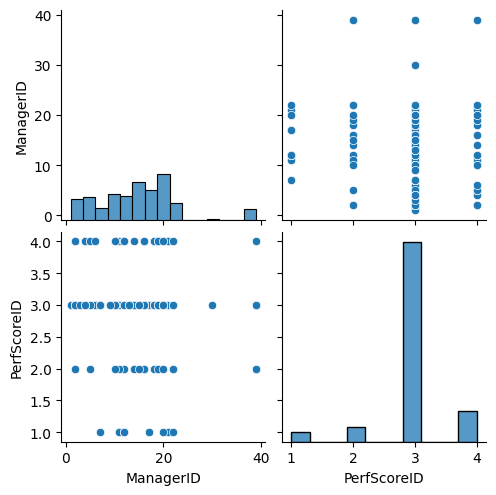

In [100]:
sns.pairplot(df[['ManagerID', 'PerfScoreID']])
plt.show()

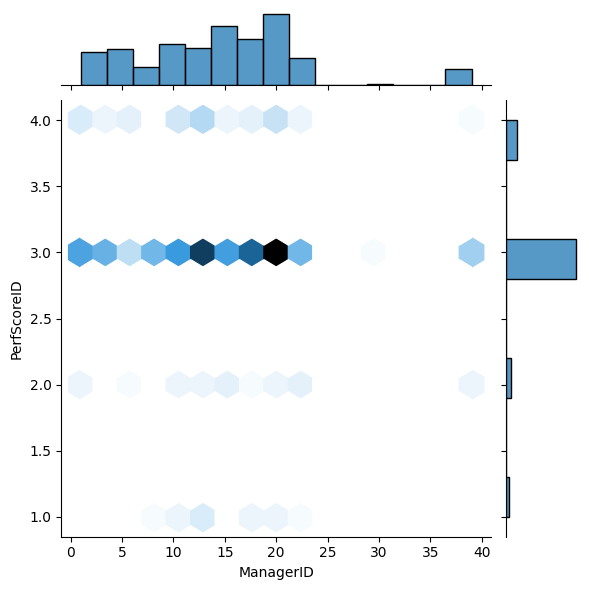

In [101]:
sns.jointplot(x='ManagerID',y='PerfScoreID',data=df,kind='hex')

<AxesSubplot:>

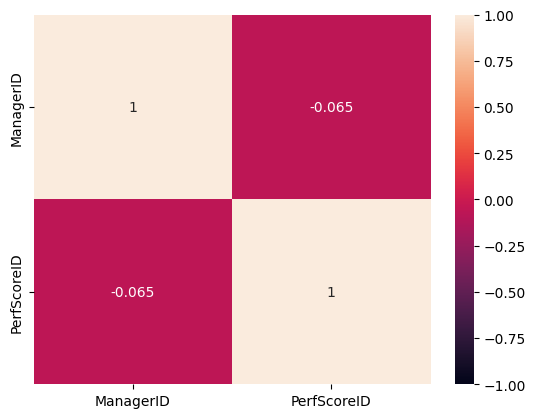

In [102]:
sns.heatmap(df[['ManagerID', 'PerfScoreID']].corr(), vmin=-1, vmax=1, annot=True)

Nie występuje zależność pomiędzy managerem a oceną wydajności pracy. Wszyscy managerowie zgodnie najczęściej wystawiają ocenę "Fully Meets".

# 2. Jakie źródła pozyskania pracownika (Recruitment Source) są najlepsze, jeśli zależy nam na jak najdłuższym stażu pracowników?

In [103]:
df['DOB'] = pd.to_datetime(df['DOB'],format='%m/%d/%y')
df['DateofTermination'] = pd.to_datetime(df['DateofTermination'],format='%m/%d/%y')
df['DateofHire'] = pd.to_datetime(df['DateofHire'],format='%m/%d/%Y')

import datetime as dt

def count_seniority(row):

    if pd.isnull(row['DateofTermination']):
        end_date = dt.datetime(2019,9,27)
    else:
        end_date = row['DateofTermination']

    return (end_date - row['DateofHire'])/np.timedelta64(1,'Y')

In [104]:
df['Seniority'] = df.apply(lambda row: count_seniority(row),axis=1)

In [105]:
df['RecruitmentSourceID'] = df.groupby('RecruitmentSource').ngroup() #nadaję ID dla RecruitmentSource

In [106]:
recruted=df[['RecruitmentSource', 'RecruitmentSourceID', 'Seniority']]

In [107]:
#tworzę zredukowaną listę RecruitmentSource, pomijam te źródła, dzięki którym zrekrutowano bardzo mało osób
r=df['RecruitmentSource'].value_counts().reset_index()
r=r[r['RecruitmentSource'] >= r['RecruitmentSource'].quantile(0.5)]
list_q=r['index']

In [108]:
def check(row):
    if row['RecruitmentSource'] in list(list_q):
        qlevel = 1
    else:
        qlevel=0
    return qlevel

In [109]:
recruted['qlevel'] = recruted.apply(lambda row: check(row),axis=1)

C:\Users\LH1\AppData\Local\Temp\ipykernel_15940\3590693997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruted['qlevel'] = recruted.apply(lambda row: check(row),axis=1)


In [110]:
results_q=recruted[recruted.qlevel==1]

RecruitmentSource                  RecruitmentSourceID
Billboard                          0                      16
Diversity Job Fair                 3                      29
Employee Referral                  4                      31
Glassdoor                          5                      14
MBTA ads                           9                      17
Monster.com                        10                     24
Newspager/Magazine                 11                     18
Pay Per Click - Google             16                     21
Professional Society               17                     20
Search Engine - Google Bing Yahoo  18                     25
Vendor Referral                    20                     15
Website Banner Ads                 21                     13
Word of Mouth                      22                     13
Name: RecruitmentSourceID, dtype: int64

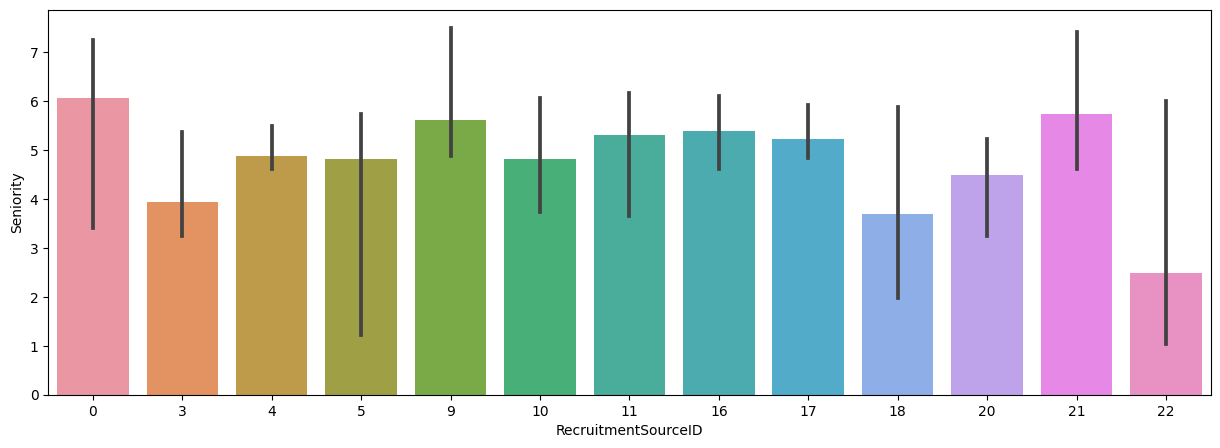

In [111]:
plt.figure(figsize=(15,5))
sns.barplot(x='RecruitmentSourceID',y='Seniority',data=results_q, estimator=np.median)
display(results_q.groupby('RecruitmentSource')['RecruitmentSourceID'].value_counts())

W mojej opinii najlepszymi źródłami zatrudnienia jeśli zależy nam na jak najdłuższym stażu jest: MBTA ads (id=9) oraz Website Banner Ads (id=21) 

# 3. Czy stan cywilny ( MartialDesc ) pracownika koreluje w jakikolwiek sposób z zadowoleniem z pracy ( EmpSatisfaction )?

MaritalStatusID  MaritalDesc
0.0              Single         137
1.0              Married        123
2.0              Divorced        30
3.0              Separated       12
4.0              Widowed          8
Name: MaritalDesc, dtype: int64

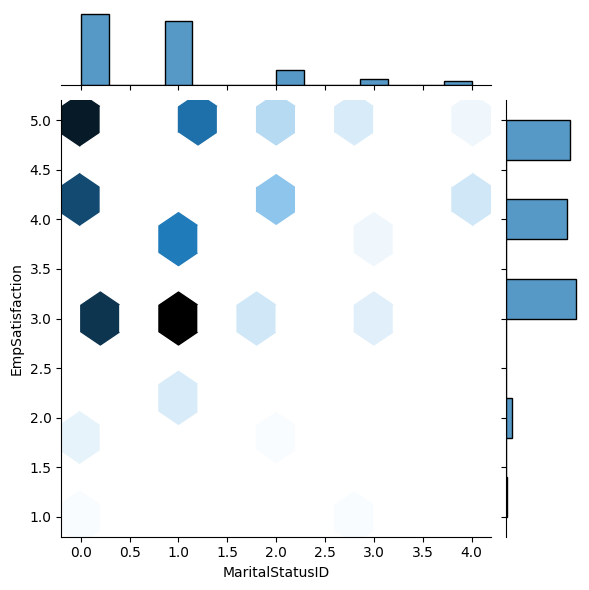

In [112]:
sns.jointplot(x='MaritalStatusID',y='EmpSatisfaction',data=df,kind='hex')
df.groupby('MaritalStatusID')['MaritalDesc'].value_counts()

<AxesSubplot:>

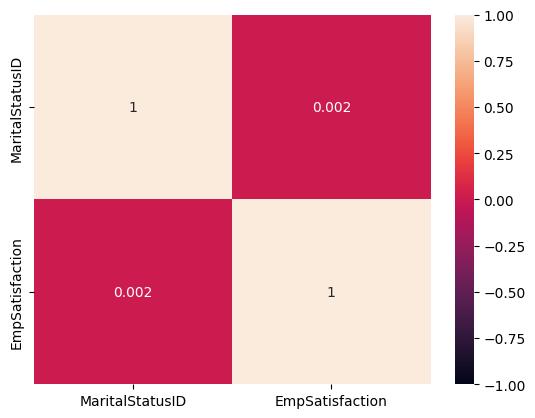

In [113]:
sns.heatmap(df[['MaritalStatusID', 'EmpSatisfaction']].corr(), vmin=-1, vmax=1, annot=True)

Brak korelacji

# 4. Jak wygląda struktura wieku aktualnie zatrudnionych pracowników?

In [114]:
from datetime import date
def count_age(row):
    born=row['DOB']
    today=date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [115]:
df['Age'] = df.apply(lambda row: count_age(row),axis=1)

In [116]:
df_age=df[df.Age>18]
df_age['Age']

0      34
1      38
2      36
3      37
4      34
       ..
302    36
304    49
306    36
307    39
309    44
Name: Age, Length: 268, dtype: int64

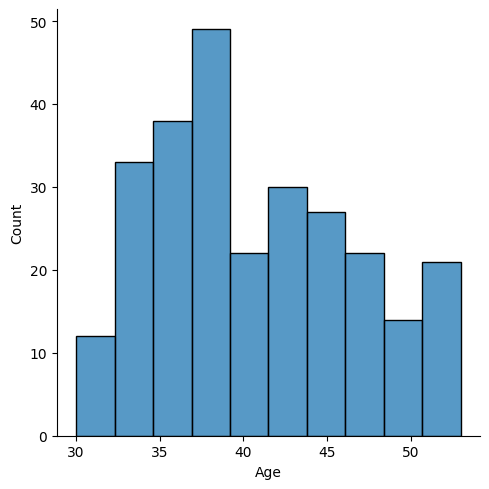

In [117]:
sns.displot(df_age['Age'])

# 5. Czy starsi pracownicy pracują nad większą liczbą specjalnych projektów niż młodsi pracownicy?

<AxesSubplot:xlabel='Age', ylabel='SpecialProjectsCount'>

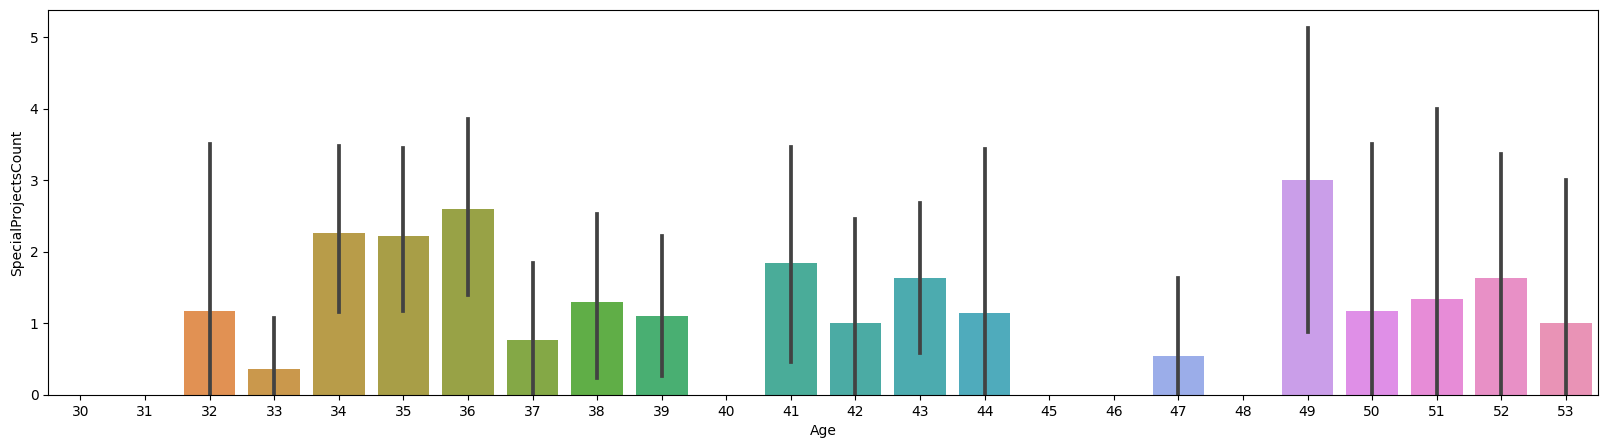

In [118]:
plt.figure(figsize=(20,5))
sns.barplot(x='Age',y='SpecialProjectsCount',data=df_age)

Starsi pracownicy nie pracują nad większą liczbą projektów specjalnych.